In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from read_data import ChestXrayDataSet
from sklearn.metrics import roc_auc_score
from model import DenseNet121
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3,4" #change to GPUs available to you

In [3]:
from catalyst.dl.runner import SupervisedRunner

In [4]:
from torch.utils.data import DataLoader

In [5]:
N_CLASSES = 14
CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
DATA_DIR = '/raid/urinbayev/Chest_images/overall'
VALID_IMAGE_LIST = 'labels/val_list.txt'
BATCH_SIZE = 8

In [6]:
cudnn.benchmark = True

# initialize and load the model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DenseNet121(N_CLASSES).to(device)




# Add the path to the model you want to check
checkpoint = torch.load('./logs/20_epochs_densenet121_RAdam_weights8_loss_2_GPUs/checkpoints/best.pth')
remove_data_parallel = False # Change if you don't want to use nn.DataParallel(model)


model.load_state_dict(checkpoint['model_state_dict'])




normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

valid_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                image_list_file=VALID_IMAGE_LIST,
                                transform=transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.TenCrop(224),
                                    transforms.Lambda
                                    (lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                    transforms.Lambda
                                    (lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ]))
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=8, pin_memory=True)



In [7]:
# initialize the ground truth and output tensor
gt = torch.FloatTensor()
gt = gt.cuda()
pred = torch.FloatTensor()
pred = pred.cuda()

# switch to evaluate mode
model.eval()
with torch.no_grad():
    for i, (inp, target) in enumerate(valid_loader):
        target = target.cuda()
        gt = torch.cat((gt, target), 0)
        bs, n_crops, c, h, w = inp.size()
        input_var = torch.autograd.Variable(inp.view(-1, c, h, w).cuda())
        output = model(input_var)
        output_mean = output.view(bs, n_crops, -1).mean(1)
        pred = torch.cat((pred, output_mean.data), 0)

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [9]:
gt_np = gt.cpu().numpy()
pred_np = sigmoid(pred.cpu().numpy())

In [10]:
gt_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
pred_np

array([[0.01525182, 0.00989946, 0.03266008, ..., 0.04589978, 0.16907439,
        0.00638738],
       [0.04779041, 0.00205888, 0.0161943 , ..., 0.19358343, 0.22837459,
        0.00288096],
       [0.06083958, 0.03821663, 0.05115195, ..., 0.27002123, 0.14831439,
        0.00312127],
       ...,
       [0.11475261, 0.2599459 , 0.6131238 , ..., 0.1253613 , 0.3695691 ,
        0.0111113 ],
       [0.12432609, 0.19259652, 0.7459152 , ..., 0.07832181, 0.43751702,
        0.01555293],
       [0.14864554, 0.53266895, 0.7427426 , ..., 0.052749  , 0.4282601 ,
        0.01962208]], dtype=float32)

In [12]:
Y_t = [] #labels for each anomaly
for i in range(14):
    Y_t.append([])
    for x in gt_np:
        Y_t[i].append(x[i])

In [13]:
Y_pred = [] #preds for each anomaly
for j in range(14):
    Y_pred.append([])
    for y in pred_np:
        Y_pred[j].append(y[j])

In [14]:
from sklearn.metrics import roc_auc_score

In [15]:
AUCs = [] # AUCs for each 
for i in range(14):
    auc = roc_auc_score(Y_t[i], Y_pred[i])
    AUCs.append(auc)

In [16]:
AUCs

[0.810366133128058,
 0.9022372256125332,
 0.8765434654401278,
 0.6923968384097519,
 0.8501844817821408,
 0.7657677223548245,
 0.7618028021524134,
 0.885482171558933,
 0.8180742018207783,
 0.9153988565205554,
 0.9008078896627847,
 0.824877179940244,
 0.8057899166411405,
 0.9291028981143273]

In [17]:
import statistics 

In [18]:
statistics.mean(AUCs)

0.8384879845099009

In [19]:
from sklearn.metrics import accuracy_score
Acc = [] # AUCs for each 
for i in range(14):
    acc = accuracy_score(Y_t[i], np.around(Y_pred[i]))
    Acc.append(acc)
Acc

[0.7317051430608789,
 0.7826900793297086,
 0.6625367679828862,
 0.5300828950886888,
 0.6707371423478028,
 0.45289241465371244,
 0.5348961583028791,
 0.7086193065335591,
 0.6654782066137802,
 0.7726178803814957,
 0.8291291558962475,
 0.6779570371690882,
 0.5948836794723238,
 0.981460023174971]

In [20]:
statistics.mean(Acc)

0.685406135000573

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
matrices=[] #for each
for i in range(14):
    matrix = confusion_matrix(Y_t[i], np.asarray(Y_pred[i])>0.6)
    matrices.append(matrix)

In [23]:
matrices[5]

array([[6157, 4449],
       [ 140,  473]])

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [25]:
def print_confusion_matrix(confusion_matrix, class_names = None, title = None ,figsize = (3,3), fontsize=20):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,)
   

    heatmap = sns.heatmap(df_cm, annot=True, fmt="d").set_title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
label_names = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural Thickening',
            'Hernia']

In [27]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

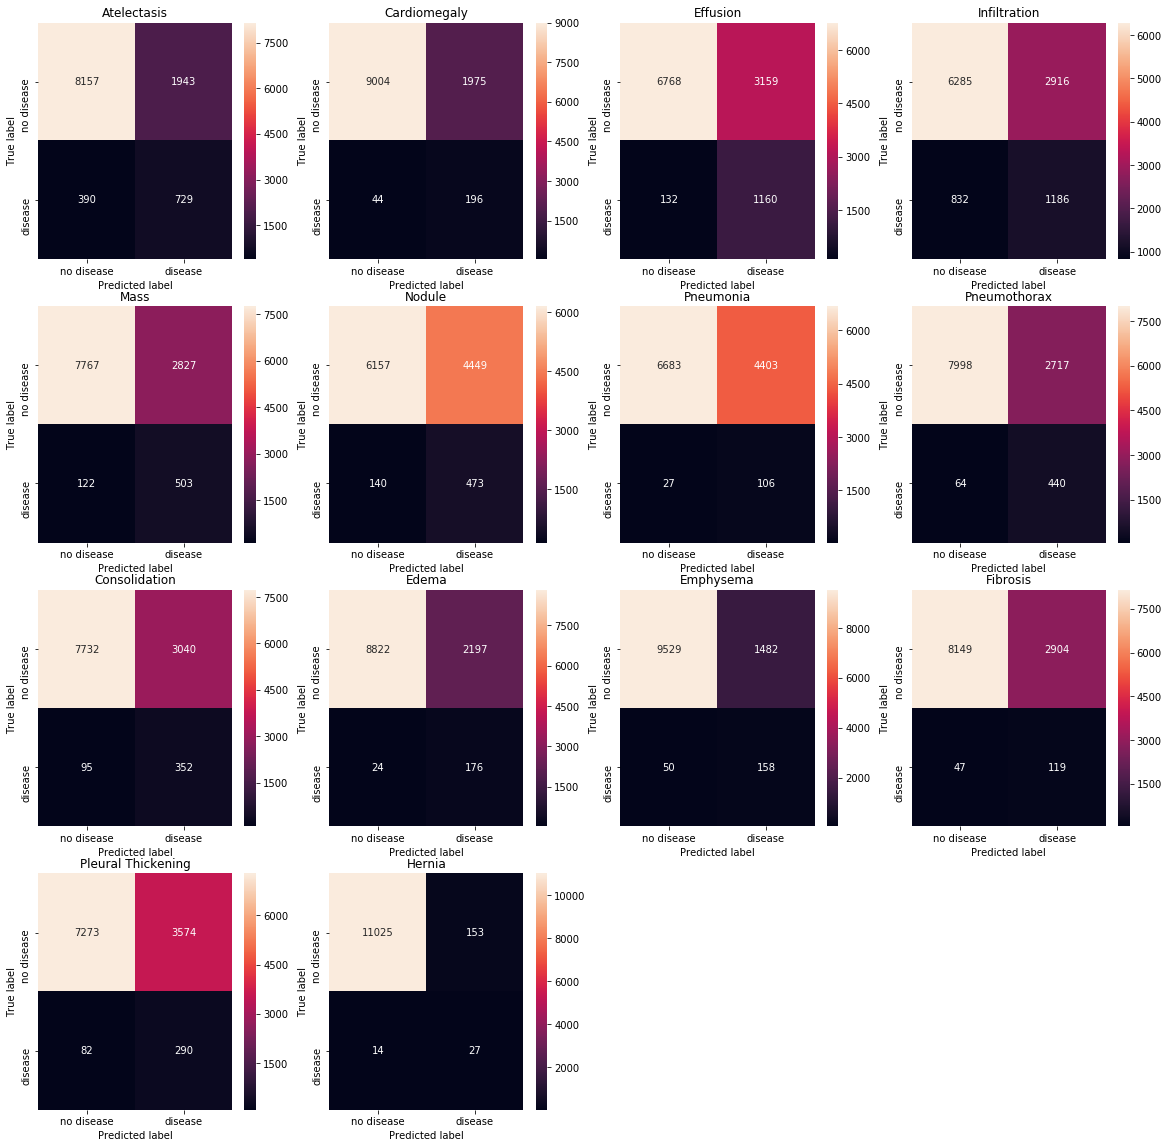

In [28]:
class_names = ['no disease', 'disease']
fig = plt.figure(figsize = (20,20))
for i in range(14):
    plt.subplot(4,4,i+1)
    
    df_cm = pd.DataFrame(
        matrices[i], index=class_names, columns=class_names,)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d").set_title(label_names[i])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    
plt.show()

In [29]:
import sklearn.metrics as metrics

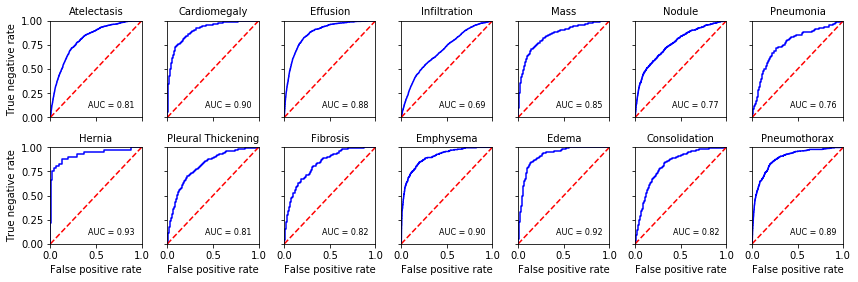

In [31]:
fig, axes2d = plt.subplots(nrows=2, ncols=7,
                           sharex=True, sharey=True,figsize = (12, 4))



for i, row in enumerate(axes2d):
    for j, cell in enumerate(row):
        if i==0:
            x=i+j
        else:
            x=13-i*j
        
        
        
        
        fpr, tpr, threshold = metrics.roc_curve(Y_t[x], Y_pred[x])
        roc_auc = metrics.auc(fpr, tpr)
        
        
        cell.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

        cell.legend(loc = 'lower right', handlelength=0,handletextpad=0,frameon=False, prop={'size': 8})

        cell.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        cell.set_title(label_names[x],fontsize=10)
        
        if i == len(axes2d) - 1:
            cell.set_xlabel('False positive rate')
        if j == 0:
            cell.set_ylabel('True negative rate')
fig.tight_layout(pad=1.0)    
plt.show()
